# I. Первый городской пространственный анализ: вспышка холеры в Лондоне


Это занятие посвящено первым шагам в анализе городских пространственных данных на Python. Оно разделено на две части.

В первой мы познакомимся с основными принципами работы с пространственными данными и изучим район Сохо в Лондоне.

Вторая часть - лабораторная работа, где приведен список небольших заданий, которые помогут проанализировать данные о смертности от вспышки холеры в 1854 году


## Импортируем библиотеки


In [1]:
import pandas as pd

import geopandas as gpd
import osmnx as ox

import numpy as np

<p style="color:#26528C; font-style:italic;">
  <strong>Pandas</strong> пригодится для обработки и анализа структурированных данных (табличек)
</p>

<p style="color:#26528C; font-style:italic;">
  <strong>Geopandas</strong> расширяет функциональность Pandas для работы с пространственными данными
</p>

<p style="color:#26528C; font-style:italic;">
  <strong>OSMnx</strong> помогает выгружать данные из OpenStreetMap
</p>

<p style="color:#26528C; font-style:italic;">
  <strong>NumPy</strong> используется для эффективных вычислений с массивами данных и матрицами, что особенно важно при анализе больших объемов пространственных данных, например, для расчета расстояний или выполнения линейной алгебры.
</p>


## 1 Создаем пространственные данные из координат


В первых двух разделах мы представим, что данных у нас совсем нет, и нужно начинать с чистого листа

Знаем только координаты интересующего нас объекта: 51.5136 с. ш. 0.1365 з. д. Именно его мы хотим отобразить на карте


### Пространственные данные из координат


Долготу и широту присваиваем переменным lat и lon, соответственно, а переменной point присваиваем словарь, в который записываем координты и название объекта


<p style="color:#26528C; font-style:italic"><strong>Словарь</strong> — это тип данных, представляющий собой коллекцию пар «ключ-значение» </p>


In [5]:
lat =  51.5136
lon =  -0.1365

point = {'Longitude': lon, 'Latitude': lat, "name": 'Soho'}

print(point)

{'Longitude': -0.1365, 'Latitude': 51.5136, 'name': 'Soho'}


На основе словаря (point) создаем DataFrame (point_df). Проверяем получившийся набор данных, чтобы убедиться, что получилось что-то похожее на таблицу


<p style="color:#26528C; font-style:italic"><strong>DataFrame</strong> - это структура данных в библиотеке Pandas, которая представляет собой двумерный массив с индексами для строк и столбцов (aka табличка)</p>


In [6]:
point_df = pd.DataFrame(point, [1])

point_df

Longitude  Latitude  name
1    -0.1365   51.5136  Soho

На основе DataFrame (point_df) создаем набор пространственных данных - GeoDataFrame с помощью библиотеки geopandas. Для этого указываем наш массив данных (point_df), определяем геометрию на основе координат и не забываем про систему координат!

Мы используем CRS 4326 - WGS84 - географическую систему координат, так как у нас широта и долгота в градусах.


<p style="color:#26528C; font-style:italic"><strong>GeoDataFrame</strong> - это расширенный DataFrame, у которого есть поле с геометрией объекта </p>


In [7]:
point_gdf = gpd.GeoDataFrame(point_df, geometry=gpd.points_from_xy(point_df['Longitude'], point_df['Latitude']), crs=4326)

Смотрим на получившийся GeoDataFrame (point_gdf) и убеждаемся, что на одно поле стало больше - добавилась геометрия


In [8]:
point_gdf

Longitude  Latitude  name                   geometry
1    -0.1365   51.5136  Soho  POINT (-0.13650 51.51360)

Согласитесь, что по результатам выше не совсем понятно, получили мы новый массив с дополнительным полем или это уже принципиально иной формат данных

Тип данных проверим, используя функцию type()


In [9]:
print(type(point_df) == type(point_gdf))

print("Тип point_df: %s, Тип point_gdf: %s" % (type(point_df), type(point_gdf)))

False
Тип point_df: <class 'pandas.core.frame.DataFrame'>, Тип point_gdf: <class 'geopandas.geodataframe.GeoDataFrame'>


Действительно, в двух переменных содержатся данные разного типа, и point_gdf - это GeoDataFrame. Значит, мы успешно создали набор пространственных данных и можем отобразить точку на карте

Для этого воспользуемся методом explore. Он использует библиотеки folium, mapclassify и matplotlib (важно, чтобы они были установлены, дополнительно импортировать в проект их не нужно)


In [11]:
point_gdf.explore()

### Сохраняем результат


Теперь мы можем сохранить полученные данные в любой из известных нам форматов с помощью метода to_file


In [12]:
#point_gdf.to_file('data/dataframe.geojson') 

## 2 Экспортируем из OSM


В ооооочень большом числе проектов используются данные OpenStreetMap. Есть множество способов, как их оттуда экспортировать.

Так как мы собираемся анализировать пространственные данные на Python, то и необходимые данные мы можем получить, не закрывая Jupyter Notebook. Для этого воспользуемся библиотекой OSMnx


Для начала стоит определить территорию, на которую мы хотим получить данные. В лабораторной вы будете работать с районом Сохо в Лондоне. Воспользуемся функцией geocode_to_gdf, чтобы получить границы района.


In [13]:
area = ox.geocode_to_gdf('Soho, London')

Посмотрим, что мы получили (а еще в методе explore зададим параметр tiles и поменяем базовую карту OSM на Positron)


In [14]:
area.explore(tiles='cartodbpositron')

Теперь попробуем выгрузить здания для района Сохо. Для этого создадим переменную tags, куда передадим ключ нужных нам объектов - buildings.
В функцию geometries_from_place передадим название района и теги объектов

Подробнее о ключах и значениях данных OSM можно прочитать <a href="https://wiki.openstreetmap.org/wiki/Map_features" target="_blank">тут</a>


In [15]:
tags = {'building': True}   

buildings = ox.features_from_place('Soho, London', tags)  #in the OSMnx versions before 1.7.0 use ox.geometries.geometries_from_place())

buildings.explore(tiles='cartodbpositron',tooltip=None)

Мы получили здания!

Теперь выберем только полигональные (и мультиполигональные) объекты


In [64]:
buildings = buildings.loc[buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]


И смело можем сохранять!

Спойлер – при сохранении возникнет ошибка, так как некоторые поля содержат данные в формате списка (list). Это не подходит для сохранения, поэтому мы это исправим: перезапишем поля как строки(string)


In [17]:
for col in buildings.columns:
    if any(isinstance(val, list) for val in buildings[col]):
        buildings = buildings.astype({col: str})

И теперь точно можем сохранять!


In [18]:
#buildings.to_file('data/soho_build.geojson')

## 3 Coordinate Reference System (CRS) -- разговоры о важном


Это очень важная тема для дальнейшей работы с пространственными данными


### Системы координат

<span style="color:#03A3A6">Системы координат(СК) - способ указания местоположения точек на поверхности Земли</span>

**Географические системы координат**

Географические системы координат знакомы нам еще со школьных уроков географии. Местоположение точки в пространстве определяется значениями широты и долготы в градусах. На основе этих координат вы сможете без дополнительной информации определить местонахождение объекта на карте.

Например, 59°57′ с. ш. 30°19′ в. д. - координаты Санкт-Петербурга <3

Одной из самых распространенных географичеcких систем координат – WGS 84. Б**о**льшая часть открытых данных, треков с мобильных устройств и пр. будут использовать эту СК.

**Прямоугольные системы координат (системы координат проекции)**

Системы координат проекции задаются на плоскости двумерной проекции, где каждая точка определяется двумя параметрами относительно центральной - начала координат. Эти параметры называются координатами X и Y.

Лишь по значениям координат точки, но не имея представление о том, в какой проекции данные, вы не сможете определить местонахождение объекта, так как начало координат всегда будет разным.

Единицы измерения - линейные, могут быть выражены метрах/километрах, футах или других единицах измерения.

![Системы координат](https://www.esri.com/arcgis-blog/wp-content/uploads/2022/02/grid2.png)
Image Source: esri.com


### EPSG

**EPSG (European Petroleum Survey Group) коды** - это числовые идентификаторы, используемые для однозначной идентификации различных систем координат, проекций и геодезических датумов. Они были разработаны Европейской группой по геодезии и разведке нефти (European Petroleum Survey Group) для использования в нефтегазовой промышленности, но теперь широко используются в геоинформационных системах (ГИС).

Например, самой популярной географической системе координат соответствует код EPSG:4326

Структура кода EPSG для UTM систем координат выглядит следующим образом:

- Для северного полушария: EPSG:326xx, где xx - номер зоны UTM
- Для южного полушария: EPSG:327xx, где xx - номер зоны UTM


#### Узнаем систему координат


In [16]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Интересно! Давайте разберемся в том, что тут написано:

Это географическая система координат, представленная двумерными координатами (широта и долгота), и ее идентификатор – EPSG:4326

- Название СК: WGS 84:
- Информация об осях: используются эллипсоидальные координаты: широта (Lat) и долгота (Lon). Единицы измерения – градусы.
- Область применения данной системы координат: весь мир
- Используемый эллипсоид: WGS 84
- Нулевой меридиан: Гринвич


<p style="color:#03A3A6; font-style:italic">  А Вы знали, что Гринвичский меридиан был установлен впервые в качестве нулевого только в 1884 году? Это решение приняли на <a href="https://ru.wikipedia.org/wiki/Международная_меридианная_конференция" target="_blank">Международной меридианной конференции</a> в Вашингтоне


#### Узнаем подходящую UTM-зону


In [17]:
buildings.estimate_utm_crs()

<Derived Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Перепроецирование


Благодаря estimate_utm_crs() мы знаем нужную нам систему координат. Давайте запишем ее в отдельную переменную, чтобы в дальнейшем можно было использовать при перепроецировании данных


In [18]:
data_crs_utm = buildings.estimate_utm_crs()
data_crs_utm

<Derived Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Для перепроецирования мы воспользуемся методом to_crs(), внутри которого укажем целевую СК


In [19]:
buildings_utm = buildings.to_crs(data_crs_utm)

print(buildings_utm.crs)

EPSG:32630


## 4. Агрегирование данных по ячейкам регулярной сетки


В этом разделе мы посчитаем плотность размещения кафе в районе Сохо в Лондоне. И для начала построим регулярные ячейки сетки


### 4.1 Квадратные ячейки


Начнем с **определения системы координат** и **пространственного охвата**. И то, и другое будет основано на слое c районами Санкт-Петербурга, чтобы покрыть ячейками весь город


**Проверяем систему координат**


In [20]:
print(area.crs.name)

WGS 84


Географическая система координат! Для удобства вычисления размера сетки и отсутствия искажений, нам нужно **перепроецировать данные в UTM**


In [21]:
#вычисляем нужную UTM зону
utm = area.estimate_utm_crs()

#перепроецируем в нее данные
admin_district_utm = area.to_crs(utm)


In [22]:
print(admin_district_utm.crs.name)

WGS 84 / UTM zone 30N


**Определяем экстент** (пространственный охват) нашего набора данных


In [25]:
#определяем границы
total_bounds = admin_district_utm.total_bounds

#записываем минимальные и максимальные значения для долготы и широты в отдельные переменные
minX, minY, maxX, maxY = total_bounds

**Выберем размер ячейки** (в метрах)


In [28]:
square_size = 200

**Создадим регулярную сетку ячеек** в рамках заданного экстента


In [30]:
from shapely.geometry import Polygon

# создаем пустой список grid_cells для хранения ячеек сетки
grid_cells = []

# устанавливаем начальные значения переменных x и y равными минимальным значениям долготы и широты соответственно
x, y = (minX, minY)

# создаем пустой массив geom_array для хранения геометрий полигонов
geom_array = []

# внешний цикл, который продолжается до тех пор, пока значение y не достигнет или не превысит максимальное значение широты
while y <= maxY:
        # внутренний цикл, который продолжается до тех пор, пока значение x не достигнет или не превысит максимальное значение долготы
        while x <= maxX:
            # создаем полигон с координатами вершин, представляющими одну ячейку сетки, и добавляем его в массив geom_array
            geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            # увеличиваем значение x на размер стороны квадрата сетки для перехода к следующей ячейке по горизонтали
            x += square_size
        # сбрасываем значение x до минимального значения долготы для начала новой строки ячеек
        x = minX
        # увеличиваем значение y на размер стороны квадрата сетки для перехода к следующей строке ячеек
        y += square_size




In [32]:
# создаем GeoDataFrame fishnet из массива геометрий geom_array и назначаем ему столбец 'id' со значениями индексов
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry'])
fishnet['id'] = fishnet.index


**Посмотрим на результат**, познакомимся с библиотекой contextily для добавления базовых карт


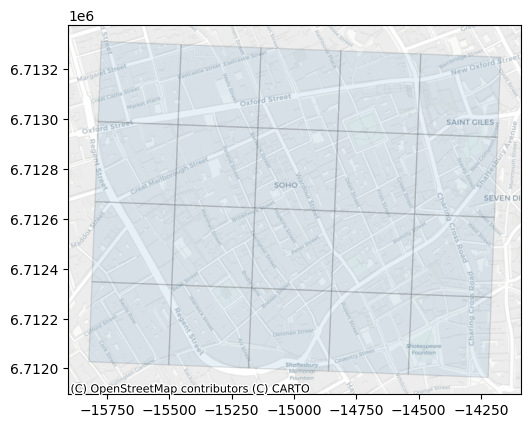

In [41]:
# импортируем библиотеку contextily
import contextily as ctx
import matplotlib.pyplot as plt

# преобразуем координаты в EPSG:3857
fishnet_3857 = fishnet.to_crs('EPSG:3857')

# создаем карту
ax = fishnet_3857.plot(alpha=0.1, edgecolor='k')

# добавляем базовую карту CartoDB из библиотеки contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# посмотрим на карту
plt.show()



**Создадим функцию** для построения сетки регулярных ячеек на основе набора данных и размера


In [44]:
def create_regular_grid(gdf, square_size):

    #вычислеяем utm зоны для набора данных 
    utm_zone = gdf.estimate_utm_crs()
    #перепроецируем набор данных
    gdf = gdf.to_crs(utm_zone)
    minX, minY, maxX, maxY = gdf.total_bounds
    
    grid_cells = []
    x, y = minX, minY

    while y <= maxY:
        while x <= maxX:
            geom = Polygon([(x, y), (x, y + square_size), (x + square_size, y + square_size), (x + square_size, y), (x, y)])
            grid_cells.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet = gpd.GeoDataFrame(geometry=grid_cells, crs=utm_zone)
    return fishnet

Проверим, как работает функция на примере набора данных buildings


In [45]:
grid = create_regular_grid(buildings, 200)

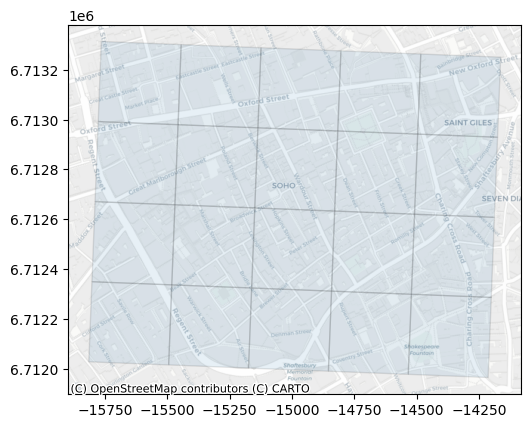

In [46]:
# преобразуем координаты в EPSG:3857
grid_3857 = grid.to_crs('EPSG:3857')

# создаем карту
ax = grid_3857.plot(alpha=0.1, edgecolor='k')

# добавляем базовую карту CartoDB из библиотеки contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# посмотрим на карту
plt.show()

### 4.2 Плотность кафе по ячейкам регулярной сетки


По аналогии с пунктами, описанными в разделе 2, экспортируем из OSM кафе в изучаемом районе


In [52]:
# Теги для кафе
tags = {'amenity': 'cafe'}

# Загрузка данных кафе из OSM для указанного места
cafes = ox.features_from_place('Soho, London', tags)

# Отображение кафе на карте
cafes.explore(tiles='cartodbpositron', tooltip=None)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)


Создаем центроды для кафе, чтобы упростить дальнейший анализ и избежать ситуации, когда одно кафе попадает в несколько ячеек


In [54]:
cafes_points = cafes.geometry.centroid
cafes_points

/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_57929/1671019256.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cafes_points = cafes.geometry.centroid


element_type  osmid     
node          372519553     POINT (-0.13120 51.51340)
              582630405     POINT (-0.14078 51.51483)
              594876703     POINT (-0.13670 51.51142)
              799284830     POINT (-0.13876 51.51455)
              1330788640    POINT (-0.13442 51.51251)
                                      ...            
way           477053975     POINT (-0.13576 51.51477)
              477794244     POINT (-0.13517 51.51528)
              993240122     POINT (-0.13050 51.51272)
              993516048     POINT (-0.13202 51.51215)
              1182798915    POINT (-0.13921 51.51416)
Length: 66, dtype: geometry

In [55]:
cafes_points = gpd.GeoDataFrame(cafes_points, columns=['geometry'])
cafes_points.explore(tiles='cartodbpositron')

Пересечем точки с кафе и полигоны регулярной сетки с помощью пространственного объединения (spatial join)


In [56]:
cafes_in_grid = gpd.sjoin(cafes_points, fishnet, predicate='within')

/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_57929/2757316530.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32630

  cafes_in_grid = gpd.sjoin(cafes_points, fishnet, predicate='within')


Упс! Ошибка! Мы о ней знали, но решили не предупреждать :) Для пространственного объединения важно, чтобы все наборы данных находились в одной системе координат!


Проверяем систему координат у кафе и у ячеек регулярной сетки:


In [57]:
print(cafes_points.crs)
print(fishnet.crs)

epsg:4326
EPSG:32630


Перепроецируем один из наборов данных


In [58]:
cafes_points_utm = cafes_points.to_crs(fishnet.crs)

Повторяем попытку пространственного объединения точек и полигонов


In [59]:
cafes_in_grid = gpd.sjoin(cafes_points_utm, fishnet, predicate='within')

In [60]:
cafes_in_grid

geometry  index_right
element_type osmid                                                   
node         372519553    POINT (699054.132 5710821.848)            8
             2273728573   POINT (698987.342 5710745.101)            8
             5451273857   POINT (698987.222 5710662.049)            8
             5463938683   POINT (698994.101 5710666.995)            8
             12123977431  POINT (699017.532 5710703.992)            8
...                                                  ...          ...
way          477053975    POINT (698732.045 5710961.524)           12
             477794244    POINT (698770.748 5711020.376)           12
             159483966    POINT (698725.254 5711037.750)           17
             273610374    POINT (698480.556 5710748.051)            5
             349935005    POINT (699124.099 5710815.647)            9

[66 rows x 2 columns]

Группируем по уникальному идентификатору ячейки и считаем количество точек кафе


In [62]:
cafes_count_in_cells = cafes_in_grid.groupby('index_right').size()
cafes_count_in_cells

Передаем полученные значения обратно в ячейки сетки


In [68]:
cafes_count_in_cells_df = cafes_count_in_cells.reset_index(name='cafes_count')

grid_cafes_count = fishnet.merge(cafes_count_in_cells_df, left_on='id', right_on='index_right', how='left')

Смотрим на результатат


In [70]:
grid_cafes_count.explore(column='cafes_count', cmap='YlGnBu', tiles='cartodbpositron')

Расчитываем плотность кафе на 1 км^2


In [79]:
grid_cafes_count['cafe_density'] = grid_cafes_count['cafes_count']/(fishnet.geometry.area/1000000)
grid_cafes_count.explore(column='cafe_density', cmap='YlGnBu', tiles='cartodbpositron')

### 4.3 Агрегирование данных на ячейки регулярной сетки


Запишем в набор данных с кафе рандомные значения "рейтинга"


In [2]:
cafes_points_utm['rating'] = np.random.randint(0, 11, size=len(cafes_points_utm))

NameError: name 'cafes_points_utm' is not defined

Пересечем данные с ячейками регулярной сетки и посчитаем среднее значение рейтинга кафе по ячейкам


In [83]:
cafes_in_grid = gpd.sjoin(cafes_points_utm, fishnet, predicate='within')

rating_mean = cafes_in_grid.groupby('id')['rating'].mean()

grid_with_rating = fishnet.merge(rating_mean, on='id', how='left')

grid_with_rating.explore(column="rating", tiles='cartodbpositron')


geometry  rating  index_right  \
element_type osmid                                                              
node         372519553    POINT (699054.132 5710821.848)       1            8   
             2273728573   POINT (698987.342 5710745.101)      10            8   
             5451273857   POINT (698987.222 5710662.049)      10            8   
             5463938683   POINT (698994.101 5710666.995)       6            8   
             12123977431  POINT (699017.532 5710703.992)       6            8   
...                                                  ...     ...          ...   
way          477053975    POINT (698732.045 5710961.524)       9           12   
             477794244    POINT (698770.748 5711020.376)       5           12   
             159483966    POINT (698725.254 5711037.750)       4           17   
             273610374    POINT (698480.556 5710748.051)      10            5   
             349935005    POINT (699124.099 5710815.647)       4            9   

                          id  cafe_density  
element_type osmid                          
node         372519553     8      0.000350  
             2273728573    8      0.000350  
             5451273857    8      0.000350  
             5463938683    8      0.000350  
             12123977431   8      0.000350  
...                       ..           ...  
way          477053975    12      0.000225  
             477794244    12      0.000225  
             159483966    17      0.000025  
             273610374     5      0.000025  
             349935005     9      0.000025  

[66 rows x 5 columns]

## 5. Построение диаграммы Вороного


По аналогии с пунктами, описанными в разделе 2, экспортируем из OSM пабы в изучаемом районе и создаем центроиды объектов


In [85]:
# Теги для пабов
tags = {'amenity': 'pub'}

# Загрузка данных о школах из OSM для Soho, London
pubs = ox.geometries_from_place('Soho, London', tags)

#Создание центроидов на основе геометрии
pubs_points = pubs.geometry.centroid
pubs_points = gpd.GeoDataFrame(pubs_points, columns=['geometry'])

# Отображение пабов на карте
pubs_points.explore(tiles='cartodbpositron')


/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_57929/4285227252.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pubs = ox.geometries_from_place('Soho, London', tags)
/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_57929/4285227252.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pubs_points = pubs.geometry.centroid


Строим диаграмму Вороного


In [86]:
from scipy.spatial import Voronoi

# 1. Перепроецируем точки пабов в подоходящую UTM зону
pubs_points_utm_zone = pubs_points.estimate_utm_crs()
pubs_points_utm = pubs_points.to_crs(pubs_points_utm_zone)



# 2. Извлекаем координаты пабов
# Преобразуем геометрические данные в координаты
pubs_coords = np.array([point.coords[0] for point in pubs_points_utm.geometry])

# 3. Строим диаграмму Вороного
vor = Voronoi(pubs_coords)

# 4. Создаем полигоны Вороного
# Переводим линии Вороного в полигоны
polygons = []
for region in vor.regions:
    if len(region) > 0 and -1 not in region:  # Убираем бесконечные регионы
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# 5. Создаем GeoDataFrame с полигонами
# Преобразуем полигоны в GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=polygons, crs=pubs_points_utm_zone)

# 6. Визуализируем результат
voronoi_gdf.explore(tiles='cartodbpositron')

### 6. Nearest Neighbour Index


NNI (Nearest Neighbor Index, индекс ближайшего соседа) — это статистическая мера, которая позволяет оценить, насколько равномерно распределены объекты в пространстве. В контексте пабов в Сохо, этот индекс может помочь оценить, насколько равномерно расположены пабы в районе.


In [92]:
from scipy.spatial.distance import cdist

In [ ]:
#1. Вычисляем расстояние между пабами (матрица расстояний)
dist_matrix = cdist(pubs_coords, pubs_coords, metric='euclidean')


# 2. Для каждого паба находим его ближайшего соседа
# Мы исключаем диагональ матрицы (расстояние до самого себя)
nearest_neighbor_distances = np.min(dist_matrix + np.eye(len(dist_matrix)) * np.max(dist_matrix), axis=1)

# 3. Вычисляем среднее расстояние до ближайшего соседа
average_nearest_neighbor_distance = np.mean(nearest_neighbor_distances)

# 4. Вычисляем площадь района Сохо
soho_polygon = ox.geocode_to_gdf("Soho, London")
soho_polygon = soho_polygon.to_crs(soho_polygon.estimate_utm_crs())
soho_area = soho_polygon.area.values[0] 

# 5. Рассчитываем ожидаемое среднее расстояния для случайного распределения точек
n = len(pubs_coords)
expected_mean_distance = 0.5 * np.sqrt(soho_area / n)

# 6. Расчсчитываем NNI (отношение среднего расстония до ближайшего соседа к ожидаемогу среднему расстоянию до ближайшего соседа)
NNI = average_nearest_neighbor_distance / expected_mean_distance
NNI


# Задание для Лабораторной №3


### Шаг 1.1 Чтение данных


In [97]:
cholera_cases = gpd.read_file('data/Cholera_deaths_ll.shp')

pumps = gpd.read_file('data/Pumps_ll.shp')


In [98]:
cholera_cases.explore(color='red', tiles='cartodbpositron') # Слой холеры


In [99]:
pumps.explore(color='blue', tiles='cartodbpositron')  # Слой насосных станций

### Шаг 1.2 Изучите данные


Какую атрибутивную информацию они содержат? На основе данных, сколько смертей произошло в районе?


### Шаг 2.1 Плотность точек


Посчитайте плотность точек по ячейкам регулярной сетки. Отобразите значения на карте


### Шаг2.2 Плотность смертельных случаев


Посчитайте плотность смертельных случаев по ячейкам регулярной сетки. Отобразите значения на карте


### Шаг2.3 Опишите полученные результаты из 2.1 и 2.2


Какие интересные закономерности можно наблюдать?


### Шаг3. Диаграмма Вороного


Постройте диаграмму Вороного от гидрантов. Отобразите значения на карте


### Шаг4. Количество смертельных случаев в зоне близости от каждого колодца


Посчитайте количество смертельных случаев в зоне близости от каждого колодца (на основе диаграммы Вороного). Отобразите значения на карте для каждого из колодцев!


### Шаг 5. Nearest Neihbour Index


Как распределены точки с зафикисированной смерностью внутри района.
Постройте гистрограмму распределения расстояний до ближайшего соседа
Рассчитайте Nearest Neihbour Index. Интерпретируйте результат


### Шаг 6. Подведите итог


Какие выводы можно сделать на основе проделанного анализа? Какие ограничения есть у используемых вами методов? С какими проблемами вы столкнулись? Какие другие методы/способы вы могли бы предложить для уточнения анализа?
